In [1]:
import keras as k
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print("loading data")
data = np.load("../Dataset/data/data_45.npy")
print("loading labels")
labels = np.load("../Dataset/data/labels_45.npy")
# тут можна вибрати різні датасети 
# під час роботи було зроблено датасет на 10 пацієнтів (~1000 фото) та 20 (~2000 фото)
# змінювати датасет підставляючи його ім'я

loading data
loading labels


In [3]:
print(data.shape)
print(labels.shape)

(4039, 224, 224, 1)
(4039,)


In [4]:
data_preview = data[:, :, :, 0]

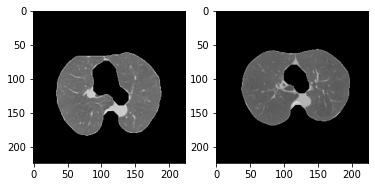

In [5]:
plt.subplot(121)
plt.imshow(data_preview[1020],cmap = 'gray')
plt.subplot(122)
plt.imshow(data_preview[1520], cmap = 'gray')

In [6]:
print(labels[1020])
print(labels[1520])

0
1


# Тренінг моделі

In [7]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.1, stratify=labels, random_state=42,shuffle = True)

In [8]:
trainX.shape

(3635, 224, 224, 1)

In [9]:
trainY.shape

(3635,)

In [10]:
testX.shape

(404, 224, 224, 1)

In [11]:
testY.shape

(404,)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
aug_train = ImageDataGenerator(rescale= 1.0/255.,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

aug_test  = ImageDataGenerator(rescale= 1.0/255.)

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.regularizers import l2

# Initialising the CNN
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = (224, 224, 1)))
classifier.add(LeakyReLU(alpha=0.1))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3)))
classifier.add(LeakyReLU(alpha=0.1))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Conv2D(64, (3, 3)))
classifier.add(LeakyReLU(alpha=0.1))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

classifier.add(Flatten())

classifier.add(Dense(units = 128))
classifier.add(LeakyReLU(alpha=0.1))
classifier.add(Dropout(0.2))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [14]:
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        3

In [16]:
import gc
def clear_gpu_memory():
# clear GPU memory
    gc.collect()
    tf.compat.v1.reset_default_graph()
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0
    config.gpu_options.visible_device_list = ""
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [17]:
import time
NAME = "model-{}".format(int(time.time()))

In [18]:
callbacks = [
#    k.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
#    k.callbacks.TensorBoard(log_dir='logs/{}'.format(NAME)),
    k.callbacks.ModelCheckpoint('logs/{}.h5'.format(NAME), save_best_only=True)]

In [ ]:
# Fit the model with class weights
hist = classifier.fit(
    aug_train.flow(
        trainX, 
        trainY, 
        batch_size=10
    ), 
    steps_per_epoch=50, 
    epochs=5,
    verbose=1,
    validation_data=(testX, testY), 
    callbacks=callbacks,
)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.6140

In [ ]:
scores = classifier.evaluate(testX, testY, steps=len(testY), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# print accuracy graph
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

In [ ]:
# print loss graph
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])

In [ ]:
classifier.save('../models/{}.h5'.format(NAME))

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

predY = classifier.predict(aug_test.flow(testX, testY, batch_size=12))
predY[predY >= 0.6] = 1
predY[predY < 0.6] = 0
cm = confusion_matrix(testY, predY)

cm_display = ConfusionMatrixDisplay(cm).plot()

predY = classifier.predict(aug_train.flow(trainX, trainY, batch_size=12))
predY[predY >= 0.6] = 1
predY[predY < 0.6] = 0
cm = confusion_matrix(trainY, predY)

cm_display = ConfusionMatrixDisplay(cm).plot()

NameError: name 'classifier' is not defined

In [ ]:
print(NAME)